In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import sklearn


In [0]:
df_movies = pd.read_csv("movies.csv")
df_ratings = pd.read_csv("ratings.csv")

In [49]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [50]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [51]:
n_users = df_ratings.userId.unique().shape[0]
n_items = df_ratings.movieId.unique().shape[0]
n_movies = df_movies.movieId.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' rated movies')
print (str(n_movies) + ' movies')

610 users
9724 rated movies
9742 movies


(array([ 4181.,  1791.,  7551.,  5550., 20047., 13136., 26818., 21762.]),
 array([0.5   , 1.0625, 1.625 , 2.1875, 2.75  , 3.3125, 3.875 , 4.4375,
        5.    ]),
 <a list of 8 Patch objects>)

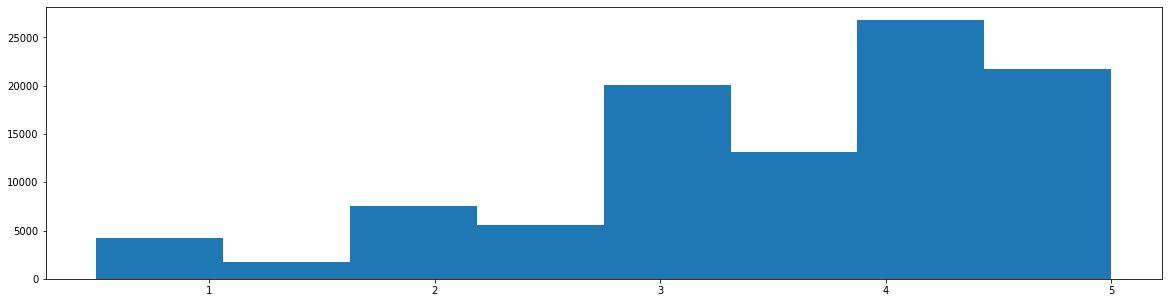

In [52]:
plt.hist(df_ratings.rating,bins=8)


In [53]:
df_ratings.groupby(["rating"])["userId"].count()


rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: userId, dtype: int64

(array([9.127e+03, 4.000e+02, 1.170e+02, 4.200e+01, 2.500e+01, 7.000e+00,
        3.000e+00, 3.000e+00]),
 array([  1.,  42.,  83., 124., 165., 206., 247., 288., 329.]),
 <a list of 8 Patch objects>)

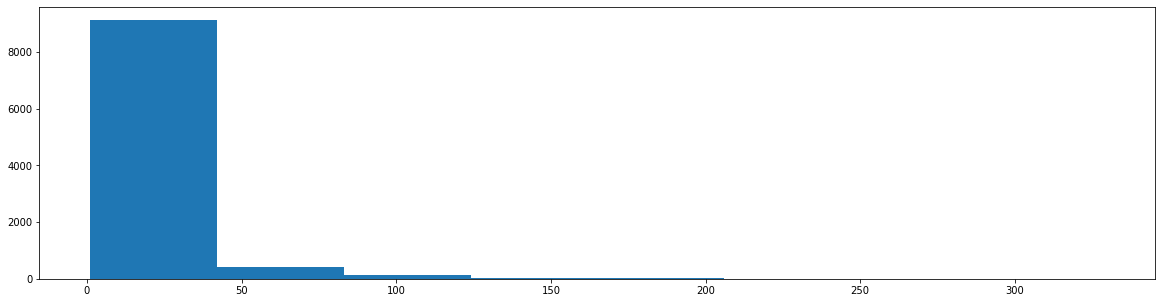

In [54]:
plt.hist(df_ratings.groupby(["movieId"])["movieId"].count(),bins=8)


In [55]:
df_matrix = pd.pivot_table(df_ratings, values='rating', index='userId', columns='movieId').fillna(0)
df_matrix

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.5,0.0,4.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,4.5,0.0,0.0,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,2.0,0.0,3.5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.5,3.5,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
ratings = df_matrix.values
sparsity = float(len(ratings.nonzero()[0]))
print(sparsity)
sparsity /= (ratings.shape[0] * ratings.shape[1])
print((ratings.shape[0] * ratings.shape[1]))
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

100836.0
5931640
Sparsity: 1.70%


In [57]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.2, shuffle=False, random_state=42)
ratings_train.shape


(488, 9724)

In [58]:
ratings_test.shape


(122, 9724)

In [0]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings)

In [60]:
sim_matrix.shape

(610, 610)

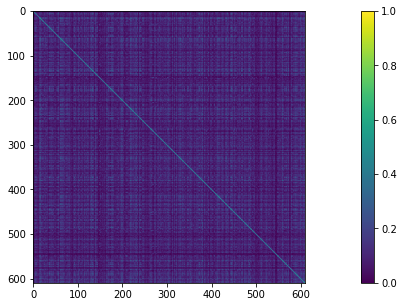

In [61]:
plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(sim_matrix);
plt.colorbar()
plt.show()

In [62]:

#separar las filas y columnas de train y test
sim_matrix_train = sim_matrix[0:488,0:488]
sim_matrix_test = sim_matrix[488:610,488:610]
print(sim_matrix_train.shape)
print(sim_matrix_test.shape)

(488, 488)
(122, 122)


In [0]:
users_predictions = sim_matrix_train.dot(ratings_train) / np.array([np.abs(sim_matrix_train).sum(axis=1)]).T

In [64]:
users_predictions.shape


(488, 9724)

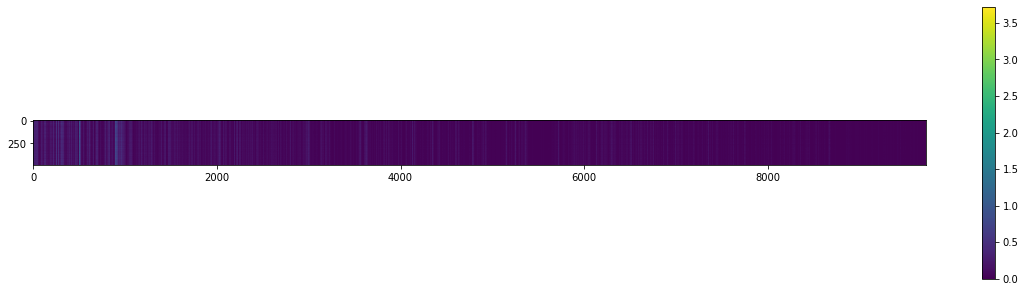

In [65]:
plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(users_predictions);
plt.colorbar()
plt.show()

In [66]:
time = 964982703 
data = df_ratings[df_ratings['timestamp'] == time]
usuario_ver = int(data.iloc[0]['userId'])  
user0=users_predictions.argsort()[usuario_ver]

# Veamos los tres recomendados con mayor puntaje en la predic para este usuario
for i, aMovie in enumerate(user0[-3:]):
    selMovie = df_movies[df_movies['movieId']==(aMovie+1)]
    print(selMovie['title'] , 'puntaje:', users_predictions[usuario_ver][aMovie])

1417    Best Years of Our Lives, The (1946)
Name: title, dtype: object puntaje: 2.6871017621355646
274    Specialist, The (1994)
Name: title, dtype: object puntaje: 2.708645687170234
240    Miami Rhapsody (1995)
Name: title, dtype: object puntaje: 3.4466560926614846


In [0]:
def get_mse(preds, actuals):
    if preds.shape[1] != actuals.shape[1]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [68]:
get_mse(users_predictions, ratings_train)

9.47812801684859

In [69]:
# Realizo las predicciones para el test set
users_predictions_test = sim_matrix.dot(ratings) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
users_predictions_test = users_predictions_test[488:610,:]

get_mse(users_predictions_test, ratings_test)

9.25157331286984